In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
# from keras.preprocessing.image import load_img
from tensorflow.keras.utils import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input
from tensorflow.keras.optimizers import SGD
import PIL
from scipy.stats import norm

## Load the dataset

In [3]:
def load_dataset():
    dir = f'{os.path.abspath(os.path.curdir)}/dataset/datasets'
    # labels - age, gender, ethnicity
    image_paths = []
    age_labels = []
    gender_labels = []

    for filename in (os.listdir(dir)):
        image_path = os.path.join(dir, filename)
        temp = filename.split('_')
        age = int(temp[0])
        gender = int(temp[1])
        image_paths.append(image_path)
        age_labels.append(age)
        gender_labels.append(gender)
    return image_paths, age_labels, gender_labels

In [4]:
# labels - age, gender, ethnicity
image_paths, age_labels, gender_labels = load_dataset()
print(f"Total_Count of Images: {len(image_paths)}")
print("Max Age value:",max(age_labels))

Total_Count of Images: 9780
Max Age value: 110


In [5]:
# convert to dataframe
data = pd.DataFrame()
data['image'], data['age'], data['gender'] = image_paths, age_labels, gender_labels
data.head()

,image,age,gender
0,c:\Users\Nishant.Sharma\Desktop\Age_Gender_Det...,100,1
1,c:\Users\Nishant.Sharma\Desktop\Age_Gender_Det...,100,1
2,c:\Users\Nishant.Sharma\Desktop\Age_Gender_Det...,101,1
3,c:\Users\Nishant.Sharma\Desktop\Age_Gender_Det...,10,0
4,c:\Users\Nishant.Sharma\Desktop\Age_Gender_Det...,10,0


## EDA

In [6]:
# Checking Outliers in Age Column
data[data['age']>100]              # only 3 entries - so not droping

,image,age,gender
2,c:\Users\Nishant.Sharma\Desktop\Age_Gender_Det...,101,1
143,c:\Users\Nishant.Sharma\Desktop\Age_Gender_Det...,110,1
144,c:\Users\Nishant.Sharma\Desktop\Age_Gender_Det...,110,1


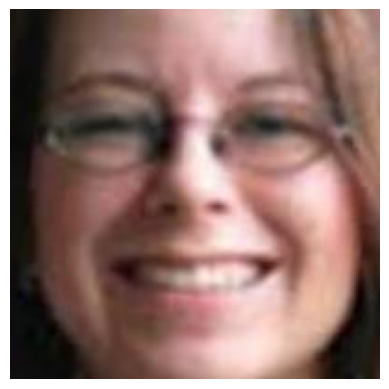

In [7]:
from PIL import Image
img = Image.open(data['image'][4780])
plt.axis('off')
plt.imshow(img);

<Axes: xlabel='age', ylabel='Density'>

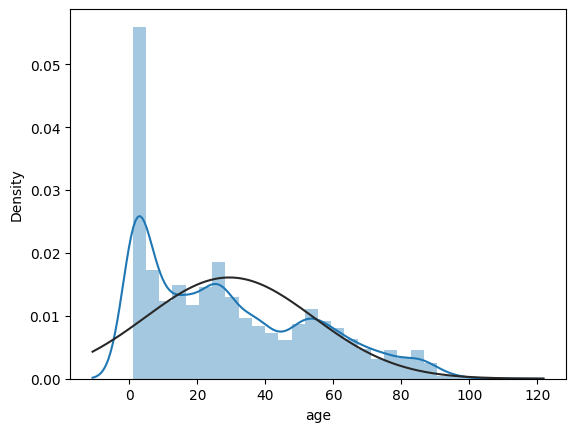

In [8]:
sns.distplot(data['age'],fit=norm)  # little right skewed

In [9]:
#Check mean,median,mode 
print(data['age'].mean(),data['age'].median(),data['age'].mode().values[0])

29.42157464212679 25.0 1


In [10]:
# Saving original dataframe
df=data.copy()

<Axes: xlabel='log_age_transformed', ylabel='Density'>

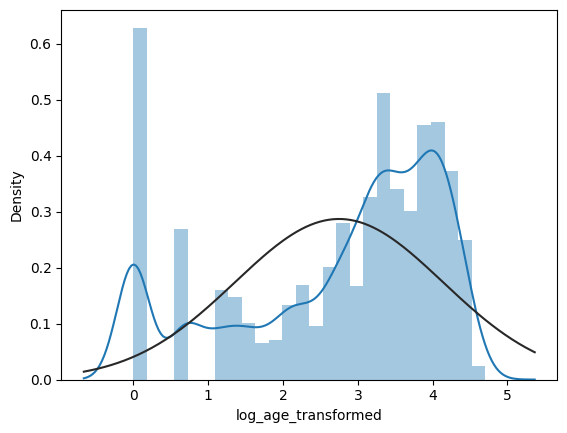

In [11]:
# Apply logarithmic transformation to the 'age' column
df['log_age_transformed'] = np.log(df['age'])

# Plot the transformed data
sns.distplot(df['log_age_transformed'],fit=norm)

<Axes: xlabel='sqrt_age_transformed', ylabel='Density'>

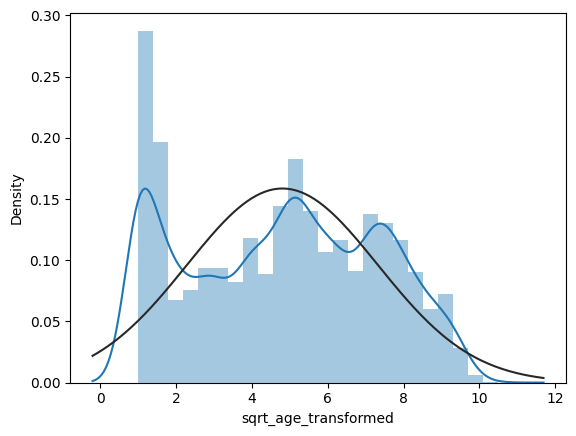

In [12]:
# Apply sqrt transformation to the 'age' column
df['sqrt_age_transformed'] = np.sqrt(df['age']).round(decimals=2)


# Plot the transformed data
sns.distplot(df['sqrt_age_transformed'],fit=norm)

In [13]:
df.drop(['age','log_age_transformed'],axis=1,inplace=True)

In [14]:
df

,image,gender,sqrt_age_transformed
0,c:\Users\Nishant.Sharma\Desktop\Age_Gender_Det...,1,10.00
1,c:\Users\Nishant.Sharma\Desktop\Age_Gender_Det...,1,10.00
2,c:\Users\Nishant.Sharma\Desktop\Age_Gender_Det...,1,10.05
3,c:\Users\Nishant.Sharma\Desktop\Age_Gender_Det...,0,3.16
4,c:\Users\Nishant.Sharma\Desktop\Age_Gender_Det...,0,3.16
...,...,...,...
9775,c:\Users\Nishant.Sharma\Desktop\Age_Gender_Det...,1,3.00
9776,c:\Users\Nishant.Sharma\Desktop\Age_Gender_Det...,1,3.00
9777,c:\Users\Nishant.Sharma\Desktop\Age_Gender_Det...,1,3.00
9778,c:\Users\Nishant.Sharma\Desktop\Age_Gender_Det...,1,3.00


In [15]:
df['gender'].value_counts()

gender
1    5407
0    4372
3       1
Name: count, dtype: int64

In [16]:
df = df[df['gender'] != 3]

In [17]:
df['gender'].value_counts()

gender
1    5407
0    4372
Name: count, dtype: int64

In [18]:
# map labels for gender
gender_dict = {0:'Male', 1:'Female'}

<Axes: xlabel='gender', ylabel='count'>

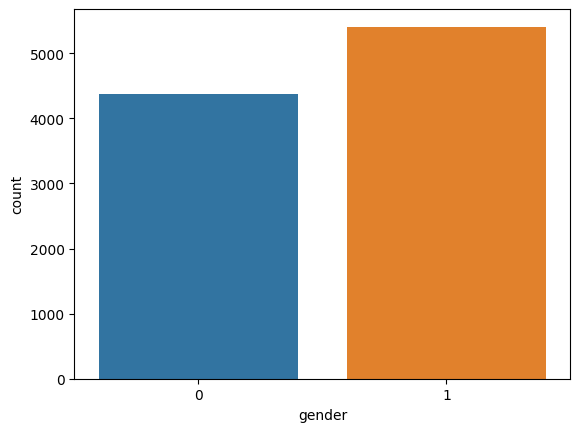

In [19]:
#plt.figure(figsize=(7,7))
sns.countplot(x=df['gender'])

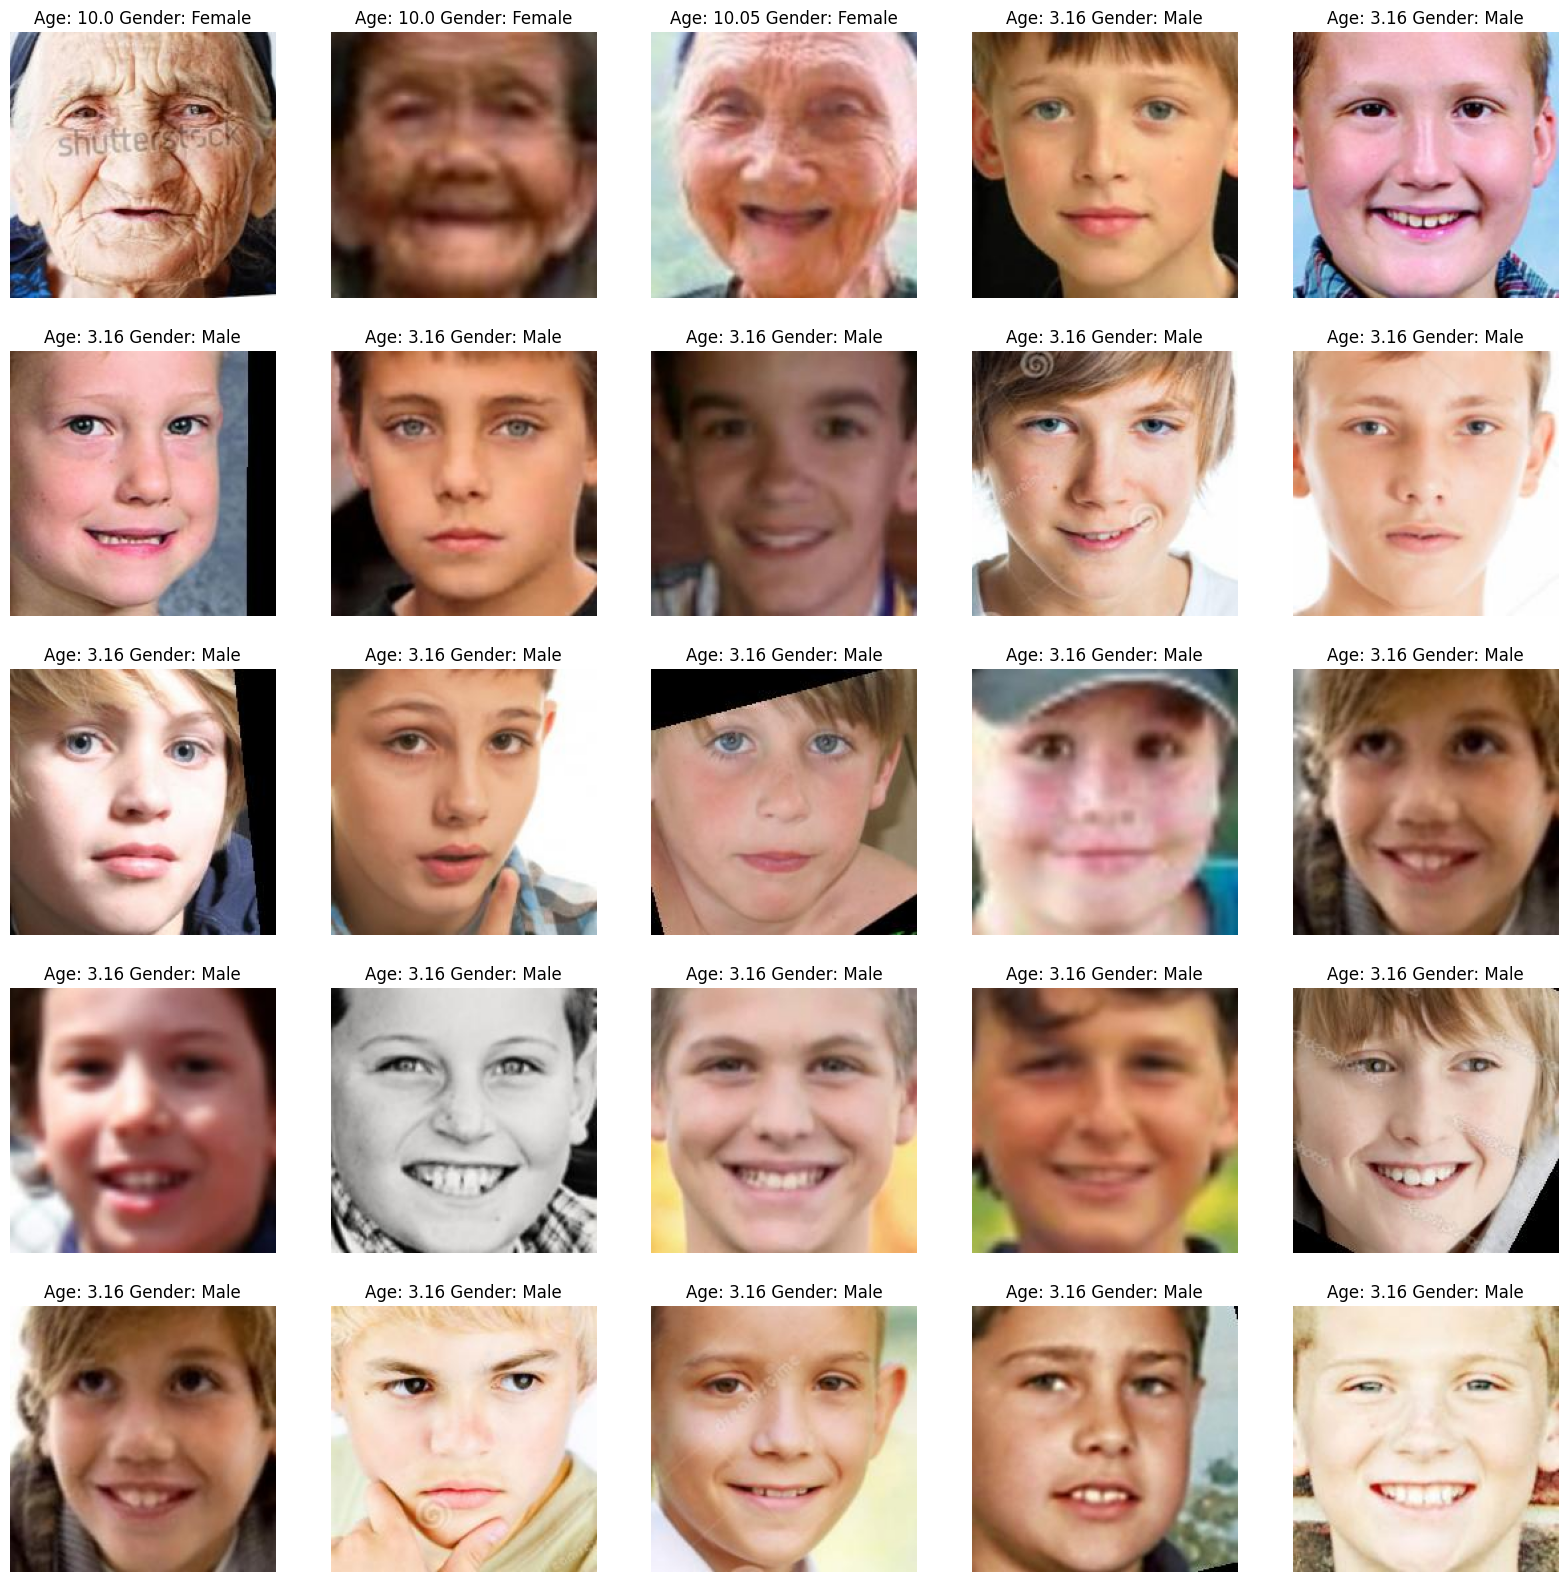

In [21]:
# to display grid of images
plt.figure(figsize=(20, 20))
files = df.iloc[0:25]

for index, file, gender, age in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = PIL.Image.open(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {age} Gender: {gender_dict[gender]}")
    plt.axis('off')

## Feature Extraction

In [22]:
def extract_features(images):
    features = []
    for image in tqdm(images):
#         img = PIL.Image.open(image,grayscale=True)
        img=load_img(image,grayscale=True)
        img = img.resize((128, 128), Image.ANTIALIAS)
        img = np.array(img)
        features.append(img)
        
    features = np.array(features)
    features = features.reshape(len(features), 128, 128, 1)
    return features

In [23]:
X = extract_features(df['image'])

  0%|          | 0/9779 [00:00<?, ?it/s]

In [24]:
X.shape

(9779, 128, 128, 1)

In [25]:
# normalize the images
# To do -> use mean standard deviation or something else
# X = X/255.0     # 255.0 is the maximum value for pixel intensity in grayscale images. 
def normalize_images(features):
    # Compute mean and standard deviation
    mean = np.mean(features)
    std = np.std(features)

    # Normalize features using mean and standard deviation
    normalized_features = (features - mean) / std

    return normalized_features

In [26]:
normalized_X = normalize_images(X)

In [27]:
normalized_X.shape

(9779, 128, 128, 1)

In [28]:
y_gender = np.array(df['gender'])
y_age = np.array(df['sqrt_age_transformed'])

## Model Creation

In [29]:
# opt = SGD(lr=0.1, momentum=0.9)

In [30]:
def Model_Creation(input_shape):
    inputs = Input((input_shape))
    # convolutional layers
    conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu') (inputs)
    maxp_1 = MaxPooling2D(pool_size=(2, 2)) (conv_1)
    conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu') (maxp_1)
    maxp_2 = MaxPooling2D(pool_size=(2, 2)) (conv_2)
    conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu') (maxp_2)
    maxp_3 = MaxPooling2D(pool_size=(2, 2)) (conv_3)
    conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu') (maxp_3)
    maxp_4 = MaxPooling2D(pool_size=(2, 2)) (conv_4)

    flatten = Flatten() (maxp_4)

    # fully connected layers
    dense_1 = Dense(256, activation='relu') (flatten)
    dense_2 = Dense(256, activation='relu') (flatten)

    dropout_1 = Dropout(0.3) (dense_1)
    dropout_2 = Dropout(0.3) (dense_2)

    output_1 = Dense(1, activation='sigmoid', name='gender_out') (dropout_1)
    output_2 = Dense(1, activation='relu', name='age_out') (dropout_2)

    model = Model(inputs=[inputs], outputs=[output_1, output_2])

    model.compile(loss=['binary_crossentropy', 'mae'], optimizer='adam', metrics=['accuracy'])

    return model

In [31]:
input_shape = (128, 128, 1)
model = Model_Creation(input_shape)

In [32]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 126, 126, 32  320         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 63, 63, 32)   0           ['conv2d[0][0]']                 
                                                                                              

In [33]:
history = model.fit(x=normalized_X, y=[y_gender, y_age], batch_size=32, epochs=15, validation_split=0.2)

Epoch 1/15
245/245 [==============================] - 102s 407ms/step - loss: 1.8785 - gender_out_loss: 0.5730 - age_out_loss: 1.3055 - gender_out_accuracy: 0.6987 - age_out_accuracy: 0.1383 - val_loss: 3.6687 - val_gender_out_loss: 0.5815 - val_age_out_loss: 3.0872 - val_gender_out_accuracy: 0.6917 - val_age_out_accuracy: 0.0000e+00
Epoch 2/15
245/245 [==============================] - 105s 429ms/step - loss: 1.3405 - gender_out_loss: 0.4552 - age_out_loss: 0.8853 - gender_out_accuracy: 0.7755 - age_out_accuracy: 0.1419 - val_loss: 2.2468 - val_gender_out_loss: 0.5095 - val_age_out_loss: 1.7373 - val_gender_out_accuracy: 0.7480 - val_age_out_accuracy: 0.0000e+00
Epoch 3/15
245/245 [==============================] - 116s 472ms/step - loss: 1.1399 - gender_out_loss: 0.3913 - age_out_loss: 0.7486 - gender_out_accuracy: 0.8017 - age_out_accuracy: 0.1421 - val_loss: 2.1898 - val_gender_out_loss: 0.5429 - val_age_out_loss: 1.6469 - val_gender_out_accuracy: 0.7520 - val_age_out_accuracy: 0.0

## Plot the result

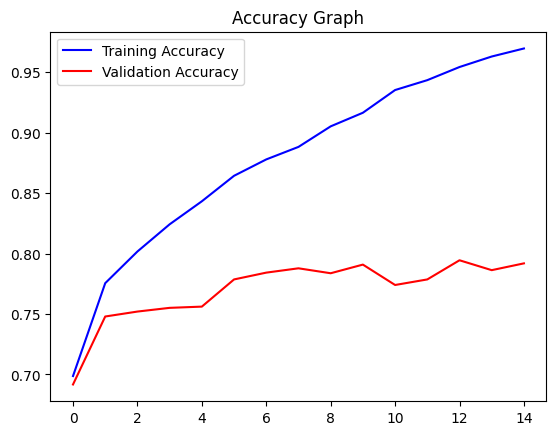

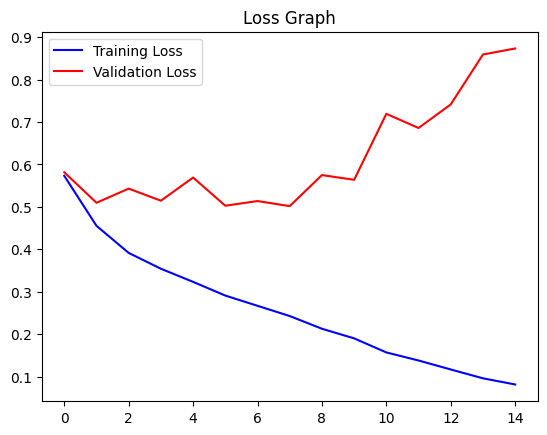

In [34]:
# plot results for gender
acc = history.history['gender_out_accuracy']
val_acc = history.history['val_gender_out_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['gender_out_loss']
val_loss = history.history['val_gender_out_loss']

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

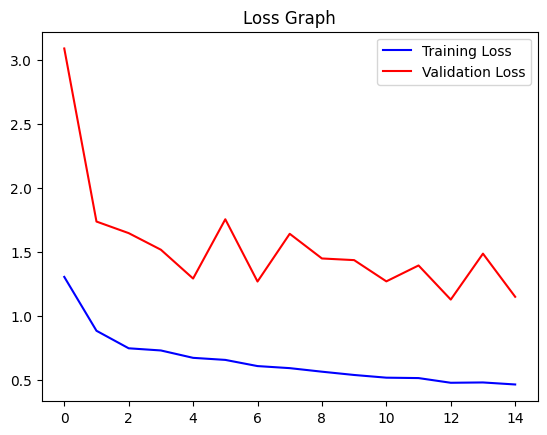

In [35]:
# plot results for age
loss = history.history['age_out_loss']
val_loss = history.history['val_age_out_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

In [36]:
## Predictions with test data

In [49]:
def predictions(image_index):
    print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", int(np.square(y_age[image_index])))
    
    # predict from model
    pred = model.predict(normalized_X[image_index].reshape(1, 128, 128, 1))

    # Predict gender
    pred_gender = gender_dict[round(pred[0][0][0])]   #anything above 0.5 is 1 else 0.

    # Predict age
    pred_age_transformed = round(pred[1][0][0])
    pred_age = np.square(pred_age_transformed)
    
    print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
    plt.axis('off')
    plt.imshow(normalized_X[image_index].reshape(128, 128,1), cmap='gray');

Original Gender: Female Original Age: 11
1/1 [==============================] - 0s 48ms/step
Predicted Gender: Female Predicted Age: 9


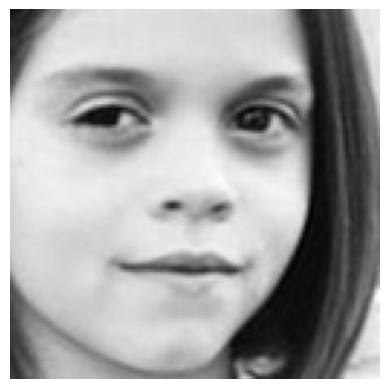

In [50]:
predictions(image_index=180)

Original Gender: Male Original Age: 37
1/1 [==============================] - 0s 57ms/step
Predicted Gender: Male Predicted Age: 49


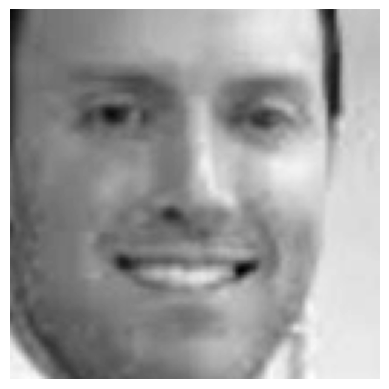

In [51]:
predictions(image_index=5150)

Original Gender: Female Original Age: 31
1/1 [==============================] - 0s 52ms/step
Predicted Gender: Female Predicted Age: 25


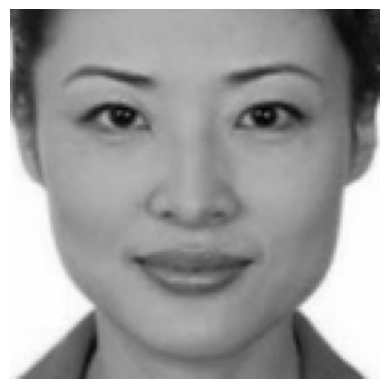

In [52]:
predictions(image_index=4500)

Original Gender: Male Original Age: 4
1/1 [==============================] - 0s 41ms/step
Predicted Gender: Male Predicted Age: 4


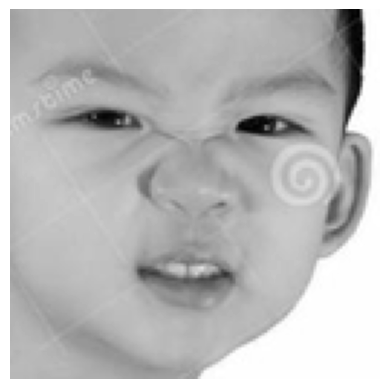

In [53]:
predictions(image_index=6399)